In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal
import soundfile as sf

# target_sr,target = scipy.io.wavfile.read('FishBite.wav')
# haystack_sr,haystack1 = scipy.io.wavfile.read('UndercityFull.wav')
# haystack1 = haystack1.astype(np.int32) * 65536
# if len(haystack1.shape) > 1:
#     haystack1 = np.mean(haystack1, axis=1).astype(np.int32)
# assert target_sr == haystack_sr
# haystack1 = haystack1[haystack_sr*60:haystack_sr*90]
# mid = len(haystack1)//2
# haystack1[mid:mid+len(target)] += target
# haystack2 = np.zeros(len(haystack1))
# haystack2[mid:mid+len(target)] += target
#scipy.io.wavfile.write('UndercityExample.wav', haystack_sr, haystack1)

target,target_sr = sf.read('FishBite.wav')
haystack1,haystack_sr = sf.read('RealCapture.wav')
# reduce to mono
if len(haystack1.shape) > 1:
    haystack1 = np.mean(haystack1, axis=1)

haystack1 = haystack1[:haystack_sr*30]
mid = len(haystack1)//2
haystack1[mid:mid+len(target)] += target
haystack2 = np.zeros(len(haystack1))
haystack2[mid:mid+len(target)] += target

# new_sr = 8000
# target = scipy.signal.decimate(target, haystack_sr//new_sr)
# haystack1 = scipy.signal.decimate(haystack1, haystack_sr//new_sr)
# haystack2 = scipy.signal.decimate(haystack2, haystack_sr//new_sr)

In [2]:
# plt.plot(scipy.signal.oaconvolve(haystack1,target[::-1], mode='full') / target_norm)
# plt.show()

  0%|          | 0/17604 [00:00<?, ?it/s]

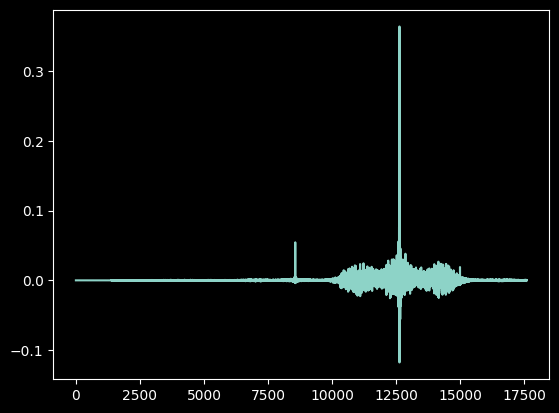

In [6]:
from numpy_ringbuffer import RingBuffer
import time
from scipy.signal import windows
from tqdm.auto import tqdm
#sr = 20_000

# suppose we have chunks of C=400 samples arriving every 10ms
# every time we receive a chunk, we want to compute the cross-correlation
# between the target, which has size N, and the last N samples received
C = 25
N = len(target)
target_norm= np.sum(target*target)

# we will store the last N samples in a ring buffer
ring = RingBuffer(capacity=N)
ring.extend(np.zeros(N))

#target_kernel = np.fft.fft(target)
corrs = []
for chunk_idx in tqdm(range(len(haystack1)//C)):
    chunk = haystack1[chunk_idx*C:(chunk_idx+1)*C]
    # add the samples one by one, computing the convolution at each step
    ring.extend(chunk)
    corr = np.sum(ring * target, axis=0) / target_norm
    corrs.append(corr)
corrs = np.array(corrs)

plt.plot(corrs)
plt.show()

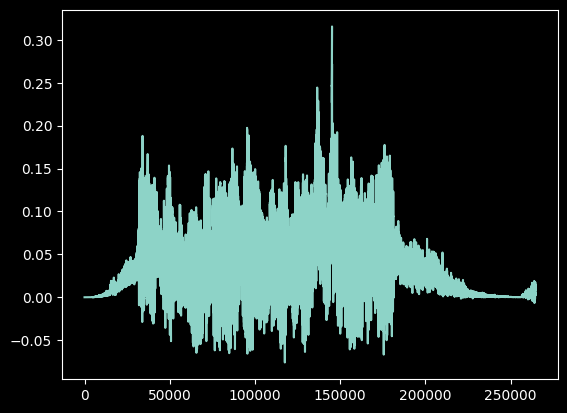

In [22]:
import numpy as np

# Parameters
sample_rate = 44100
chunk_size = 5  # 10 ms of samples
window_size = 1024  # Sliding window size

# Precompute FFT of the filter kernel
target_fft = np.fft.rfft(target, n=window_size)

# Circular buffer to hold the sliding window
circular_buffer = np.zeros(window_size)

def process_chunk(chunk):
    global circular_buffer
    # Update the sliding window
    circular_buffer = np.roll(circular_buffer, -chunk_size)
    circular_buffer[-chunk_size:] = chunk

    # Compute FFT of the current sliding window
    window_fft = np.fft.rfft(circular_buffer)

    # Perform correlation in the frequency domain
    result_fft = window_fft * np.conj(target_fft)
    result = np.fft.irfft(result_fft)

    # Process the result (e.g., extract features, detect peaks, etc.)
    return result

# Simulate receiving audio in chunks
corrs = []
def simulate_audio_stream(audio_stream):
    for i in range(0, len(audio_stream), chunk_size):
        chunk = audio_stream[i:i + chunk_size]
        if len(chunk) == chunk_size:
            correlation = process_chunk(chunk)
            # Use the correlation result
            corrs.append(correlation.max())

simulate_audio_stream(haystack1)

plt.plot(corrs)
plt.show()